# Add Libraries and select the number of clusters

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from meteostat import Hourly, Point
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time
import swifter
number_of_clusters = 25
sns.set_theme()

# Read The Data

In [2]:
data = pd.read_csv('../ar41_for_ulb.csv', sep=';', index_col=0)
data['timestamps_UTC'] = pd.to_datetime(data.timestamps_UTC)
data['mapped_veh_id'] = data.mapped_veh_id.apply(str)
data.head()

,mapped_veh_id,timestamps_UTC,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
0,181.0,2023-08-01 03:44:12,50.769818,3.872114,27.0,23.0,255.0,238.0,794.0,801.0,83.0,81.0,76.0,77.0
1,143.0,2023-08-01 06:36:29,51.039993,3.693429,33.0,32.0,272.0,324.0,802.0,804.0,78.0,78.0,73.0,74.0
2,183.0,2023-08-24 06:53:54,50.742203,3.602035,31.0,33.0,234.0,182.0,799.0,802.0,82.0,82.0,85.0,87.0
3,177.0,2023-08-01 13:53:38,50.930914,5.327132,35.0,38.0,220.0,244.0,794.0,801.0,77.0,81.0,78.0,82.0
4,143.0,2023-08-24 07:02:30,51.180773,3.575259,41.0,34.0,227.0,282.0,806.0,800.0,85.0,78.0,82.0,79.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17679273 entries, 0 to 17679272
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   mapped_veh_id       object        
 1   timestamps_UTC      datetime64[ns]
 2   lat                 float64       
 3   lon                 float64       
 4   RS_E_InAirTemp_PC1  float64       
 5   RS_E_InAirTemp_PC2  float64       
 6   RS_E_OilPress_PC1   float64       
 7   RS_E_OilPress_PC2   float64       
 8   RS_E_RPM_PC1        float64       
 9   RS_E_RPM_PC2        float64       
 10  RS_E_WatTemp_PC1    float64       
 11  RS_E_WatTemp_PC2    float64       
 12  RS_T_OilTemp_PC1    float64       
 13  RS_T_OilTemp_PC2    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 2.0+ GB


# Make a k means
Select a minimum and maximum data. Then make a kmeans with the amount of clusters previously defined. Plot the points in the data set and overlap the cluster centers in red.

You may notice that there are some outliers, that is to be expected since the data has not been cleaned.

In [4]:
mn, mx = np.min(data['timestamps_UTC']) , np.max(data['timestamps_UTC'])
mn_datetime = datetime(mn.year, mn.month, mn.day)
mx_datetime = datetime(mx.year, mx.month, mx.day)
print(mn,mx)

2022-08-22 14:31:20 2023-09-13 21:52:58


In [5]:
x_k_means = data[['lat','lon']]
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0, n_init="auto").fit(x_k_means)
data['cluster_label'] = kmeans.labels_

Text(0.5, 1.0, 'Clusters for the weather')

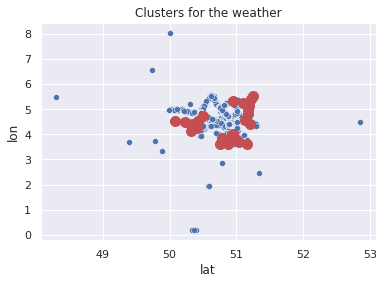

In [6]:
ax = sns.scatterplot(data, x = 'lat', y = 'lon')
for cc in kmeans.cluster_centers_:
    ax.plot(cc[0], cc[1], '-ro',  markersize=10)
ax.set_title("Clusters for the weather")

# Make the request to meteostat API

There is a `time.sleep(5)` that ensures we don't get rate limits. Without it, the api call fails. There is also a very cool animation for loading.

In [7]:
meteostat_points = [ Point (cc[0],cc[1], None ) for cc in kmeans.cluster_centers_]
information_non_fetched = [Hourly(point, start=mn_datetime, end=mx_datetime) for point in meteostat_points]
information = []
print('='*len(information_non_fetched))
for info in information_non_fetched:
    information.append(info.fetch())
    time.sleep(5)
    print('=', end ='')

# Join the tables
The join is on the key `timestamps_UTC` using an approximation to the nearest hour. Thus I first construct a naive index and then join them

In [8]:
small_index = information[0].index
aux_col = data['timestamps_UTC'].swifter.apply(lambda x: small_index.get_indexer([x], method='pad')[0])

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [9]:
all_information = pd.concat([i.reset_index() for i in information]).reset_index( drop=True)
location_in_information = np.array(aux_col)
all_locations = (kmeans.labels_ * len(information[0]))+location_in_information
data_to_concat = all_information.iloc[all_locations].reset_index( drop=True)

### Delete the data because it is no longer necessary to have it in memory

In [11]:
data = pd.concat([data, data_to_concat.drop(['time'], axis = 1)], axis = 1)
del data_to_concat

In [12]:
data.head()

,mapped_veh_id,timestamps_UTC,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,181.0,2023-08-01 03:44:12,50.769818,3.872114,27.0,23.0,255.0,238.0,794.0,801.0,...,14.2,93.0,0.0,NaN,250.0,10.8,NaN,1000.7,NaN,2.0
1,143.0,2023-08-01 06:36:29,51.039993,3.693429,33.0,32.0,272.0,324.0,802.0,804.0,...,13.5,89.0,0.0,NaN,254.0,20.5,27.8,1001.0,NaN,2.0
2,183.0,2023-08-24 06:53:54,50.742203,3.602035,31.0,33.0,234.0,182.0,799.0,802.0,...,15.7,87.0,0.0,NaN,94.0,11.9,NaN,1013.9,NaN,2.0
3,177.0,2023-08-01 13:53:38,50.930914,5.327132,35.0,38.0,220.0,244.0,794.0,801.0,...,13.1,65.0,0.0,NaN,276.0,15.5,NaN,1002.8,NaN,3.0
4,143.0,2023-08-24 07:02:30,51.180773,3.575259,41.0,34.0,227.0,282.0,806.0,800.0,...,17.9,86.0,0.0,NaN,109.0,7.4,14.8,1014.9,NaN,3.0


# Save the data

In [13]:
data.to_csv('data_augmented_big.csv',index= False)